<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Data-Analysis-Projects-With-Pandas/blob/master/5.%20Transportation%20and%20Logistics/Bike%20Sharing%20Prediction/bike_sharing_boosting_algorithms_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Enviorment

### Download Dataset

In [1]:
#!/bin/bash
!kaggle datasets download lakshmi25npathi/bike-sharing-dataset
!unzip bike-sharing-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset
License(s): unknown
  0% 0.00/286k [00:00<?, ?B/s]
100% 286k/286k [00:00<00:00, 60.2MB/s]
Archive:  bike-sharing-dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


### Install Libraries

In [2]:
%%bash
pip install -q xgboost lightgbm category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 25.6 MB/s eta 0:00:00


### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,)
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor,
                              GradientBoostingRegressor)

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Import Dataset

In [4]:
df_day = pd.read_csv('day.csv')
df_hour = pd.read_csv('hour.csv')

# Analyzing Dataset

In [5]:
# ===================== #
# Analyze DataFrame
# ===================== #

def analyze_df(df, dataset_name, display_head=True, summary_stats=True):
    """
    Analyzes a given DataFrame and prints useful information about it.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        dataset_name (str): Name of the dataset for display purposes.
        display_head (bool): If True, display the first few rows of the DataFrame.
        summary_stats (bool): If True, include summary statistics for numeric columns.

    Returns:
        None
    """
    # DataFrame Analysis
    print(f"{'-'*40}\nAnalyzing '{dataset_name}' DataFrame\n{'-'*40}\n")
    print(f"Number of Rows: {df.shape[0]} | Number of Columns: {df.shape[1]}")
    print("\nColumn Overview:")
    print(df.info())

    # Check Missing Values
    print(f"\n{'-'*40}\n Missing Values \n{'-'*40}\n")
    print("Missing Values: ")
    nans = df.isna().sum()
    if nans.sum() > 0:
        print(nans[nans > 0])
    else:
        print("No Missing Values...")

    # Check Dupes
    print(f"\n{'-'*40}\n Duplicated Rows \n{'-'*40}\n")
    dupes = df.duplicated().sum()
    print(f"Number of Duplicates: {dupes}")

    # Statistical Analysis
    print(f"\n{'-'*40}\n {dataset_name} Statistical Summary \n{'-'*40}\n")
    if summary_stats:
        print("Summary Statistics:")
        print(df.describe())

    if display_head:
        print(f"\n{'-'*40}\n DataFrame Sample \n{'-'*40}\n")
        print("\nFirst Few Rows:")
        return df.head()

    print(f"\n{'-'*40}\nAnalysis Complete for '{dataset_name}'\n{'-'*40}")

In [6]:
analyze_df(df_day, 'df_day')

----------------------------------------
Analyzing 'df_day' DataFrame
----------------------------------------

Number of Rows: 731 | Number of Columns: 16

Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
analyze_df(df_hour, 'df_hour', summary_stats=False)

----------------------------------------
Analyzing 'df_hour' DataFrame
----------------------------------------

Number of Rows: 17379 | Number of Columns: 17

Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Variables :

| **Column**      | **Description**                                                                 | **Data Type** | **Notes**                                    |
|------------------|---------------------------------------------------------------------------------|---------------|----------------------------------------------|
| `instant`       | Index of records. A unique identifier for each row.                            | `int64`       | Acts as a primary key or row ID.             |
| `dteday`        | Date of the record.                                                            | `object`      | Format: YYYY-MM-DD.                          |
| `season`        | Season of the year (1: Winter, 2: Spring, 3: Summer, 4: Fall).                 | `int64`       | Categorical variable.                        |
| `yr`            | Year of the record (0: 2011, 1: 2012).                                         | `int64`       | Categorical, representing two years.         |
| `mnth`          | Month of the year (1 to 12).                                                   | `int64`       | Numerical representation of months.          |
| `hr`            | Hour of the day (0 to 23).                                                     | `int64`       | Represents the time in 24-hour format.       |
| `holiday`       | Whether the day is a holiday (0: No, 1: Yes).                                  | `int64`       | Binary categorical variable.                 |
| `weekday`       | Day of the week (0: Sunday, 1: Monday, ..., 6: Saturday).                      | `int64`       | Categorical variable.                        |
| `workingday`    | Whether the day is a working day (0: No, 1: Yes).                              | `int64`       | Binary categorical variable.                 |
| `weathersit`    | Weather situation (1: Clear, 2: Mist, 3: Light Rain/Snow, 4: Heavy Rain/Snow). | `int64`       | Ordinal variable.                            |
| `temp`          | Normalized temperature in Celsius.                                             | `float64`     | Ranges between 0 and 1.                      |
| `atemp`         | Normalized "feeling" temperature in Celsius.                                   | `float64`     | Ranges between 0 and 1.                      |
| `hum`           | Normalized humidity.                                                           | `float64`     | Ranges between 0 and 1.                      |
| `windspeed`     | Normalized wind speed.                                                         | `float64`     | Ranges between 0 and 1.                      |
| `casual`        | Number of casual (non-registered) users.                                       | `int64`       | Count of casual bike rentals.                |
| `registered`    | Number of registered users.                                                    | `int64`       | Count of registered bike rentals.            |
| `cnt`           | Total count of bike rentals (casual + registered).                             | `int64`       | Target variable representing total rentals.  |

#### Notes:
- **Categorical Variables**: `season`, `yr`, `holiday`, `weekday`, `workingday`, `weathersit` are categorical but stored as integers.
- **Target Variable**: `cnt` is typically the variable to predict in bike rental prediction models.
- **Normalization**: `temp`, `atemp`, `hum`, and `windspeed` are normalized features, scaled to a range of 0 to 1.


### Statistical Summary Of `df_hour`

In [8]:
df_hour.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


# Preprocessing

### Correct Column's Name

In [9]:
df_hour.rename(columns={
    'dteday': 'date',
    'yr': 'year',
    'mnth': 'month',
    'hr': 'hour',
    'holiday': 'is_holiday',
    'weekday': 'day_of_week',
    'workingday': 'is_working_day',
    'weathersit': 'weather_situation',
    'atemp': 'feels_like_temp',
    'hum': 'humidity',
    'windspeed': 'wind_speed',
    'registered': 'registered_count',
    'cnt': 'total_count'
}, inplace=True)

In [10]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   instant            17379 non-null  int64  
 1   date               17379 non-null  object 
 2   season             17379 non-null  int64  
 3   year               17379 non-null  int64  
 4   month              17379 non-null  int64  
 5   hour               17379 non-null  int64  
 6   is_holiday         17379 non-null  int64  
 7   day_of_week        17379 non-null  int64  
 8   is_working_day     17379 non-null  int64  
 9   weather_situation  17379 non-null  int64  
 10  temp               17379 non-null  float64
 11  feels_like_temp    17379 non-null  float64
 12  humidity           17379 non-null  float64
 13  wind_speed         17379 non-null  float64
 14  casual             17379 non-null  int64  
 15  registered_count   17379 non-null  int64  
 16  total_count        173

### Correcting Datatypes

In [11]:
#======================#
#       Datetime       #
#======================#

df_hour['date'] = pd.to_datetime(df_hour['date'])

# Visualization

In [12]:
#======================#
#    Common Methods    #
#======================#

# Categorical
def countplot(df, col, legend_value=None):
    """
    Creates and displays a countplot for a specified column in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the data.
    col : str
        The name of the column to visualize with a countplot.

    Returns:
    --------
    None
        Displays the countplot.
    """

    plt.figure(figsize=(5, 5))
    sns.set_style("darkgrid")
    sns.countplot(x=col,
                  data=df,
                  palette='viridis')
    plt.title(f"{col} Countplot", fontsize=15, fontweight='bold')
    plt.xlabel(f"{col}", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Numeric Values
def dist(df, col):
    """
    Creates and displays a distribution plot for a numeric column in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing the data.
    col : str
        The name of the numeric column to visualize.

    Returns:
    --------
    None
        Displays the distribution plot.
    """
    # Validate inputs
    if col not in df.columns:
        raise ValueError(f"Column '{col}' does not exist in the DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[col]):
        raise TypeError(f"Column '{col}' must be numeric to plot a distribution.")

    plt.figure(figsize=(7, 5))
    sns.set_style("darkgrid")
    sns.histplot(df[col],
                 kde=True,
                 color='darkblue',
                 bins=30, edgecolor='black')
    plt.title(f"{col} Distribution", fontsize=15, fontweight='bold')
    plt.xlabel(f"{col}", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

# Aggregated Barplot
def barplot_aggregated(data, col, agg_col, title, x_labels=None):
    """
    Creates and displays a bar plot for aggregated values grouped by a categorical column.

    Parameters:
    -----------
    data : pandas.DataFrame
        The input DataFrame containing the data.
    col : str
        The name of the categorical column to group by.
    agg_col : str
        The name of the column to aggregate (e.g., compute mean, sum).
    title : str
        The title of the plot.
    x_labels : dict, optional
        A dictionary mapping numeric categories to descriptive labels for the x-axis.

    Returns:
    --------
    None
        Displays the bar plot.
    """
    # Aggregate data
    agg_data = data.groupby(col)[agg_col].mean()

    # Map x-axis labels if provided
    if x_labels:
        agg_data.index = agg_data.index.map(x_labels)

    # Plot the aggregated values
    plt.figure(figsize=(7, 5))
    sns.barplot(x=agg_data.index, y=agg_data.values, palette="viridis")
    plt.title(title, fontsize=15, fontweight='bold')
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel(f"Average {agg_col.capitalize()}", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()


# Scatter Plot
def scatter_plot(df, x_col, y_col, hue_col=None, title=None, x_label=None, y_label=None, palette='muted'):
    """
    Function to create a scatter plot.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - x_col (str): The column name for the x-axis.
    - y_col (str): The column name for the y-axis.
    - hue_col (str, optional): The column name for grouping data by color. Default is None.
    - title (str, optional): The title of the plot. Default is None.
    - x_label (str, optional): The label for the x-axis. Default is None (uses x_col).
    - y_label (str, optional): The label for the y-axis. Default is None (uses y_col).
    - palette (str, optional): The color palette for the scatter plot. Default is 'muted'.

    Returns:
    None
    """
    plt.figure(figsize=(8, 5))
    sns.set_style("darkgrid")
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette=palette)

    # Set plot title and axis labels
    plt.title(title or f"{x_col} vs {y_col}", fontsize=15, fontweight='bold')
    plt.xlabel(x_label or x_col, fontsize=12)
    plt.ylabel(y_label or y_col, fontsize=12)

    if hue_col:
        plt.legend(title=hue_col)
    plt.show()

### Countplot

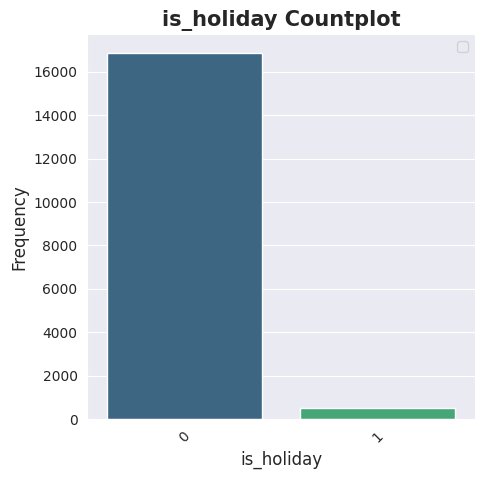

In [13]:
countplot(df_hour, 'is_holiday',)

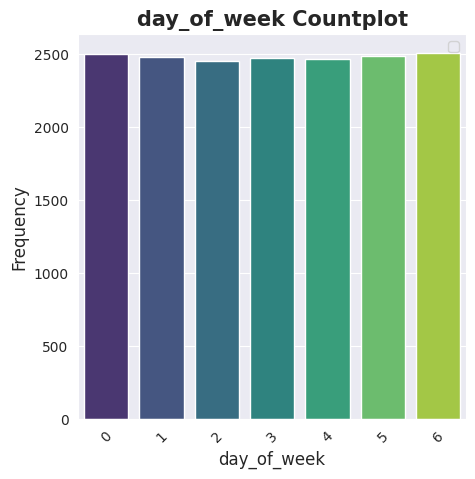

In [14]:
countplot(df_hour, 'day_of_week')

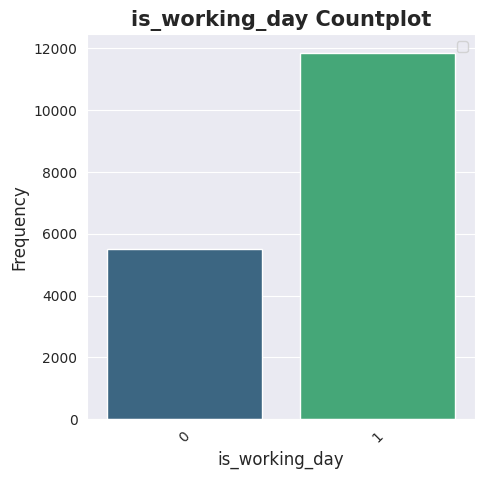

In [15]:
countplot(df_hour, 'is_working_day')

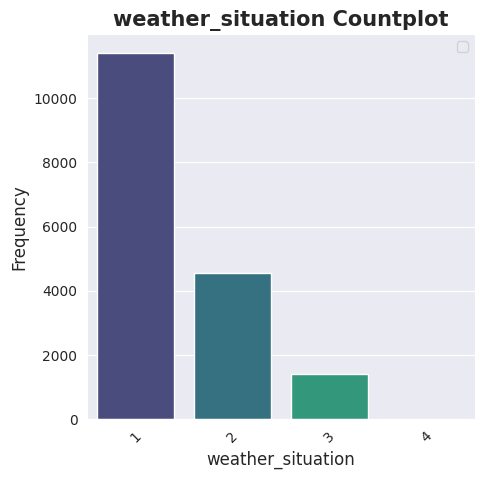

In [16]:
countplot(df_hour, "weather_situation")
# (1: Clear, 2: Mist, 3: Light Rain/Snow, 4: Heavy Rain/Snow)

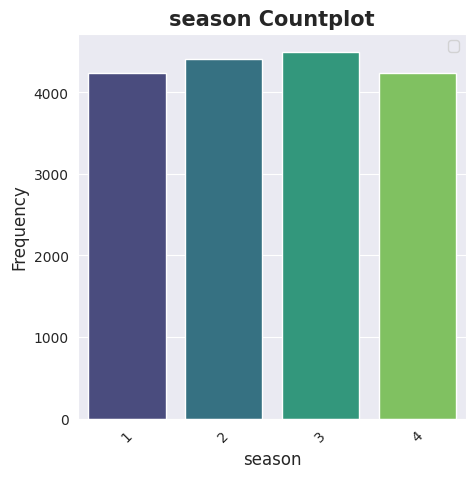

In [17]:
countplot(df_hour, 'season')

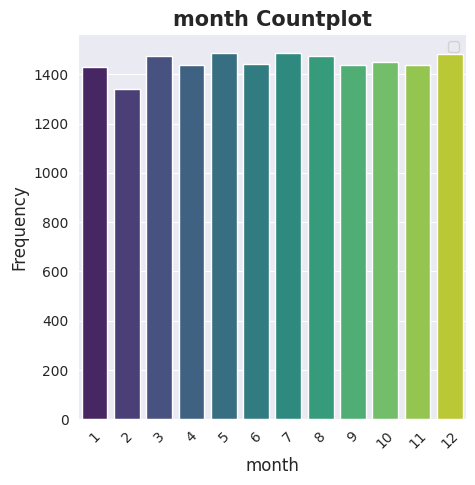

In [18]:
countplot(df_hour, 'month')

### Distribution

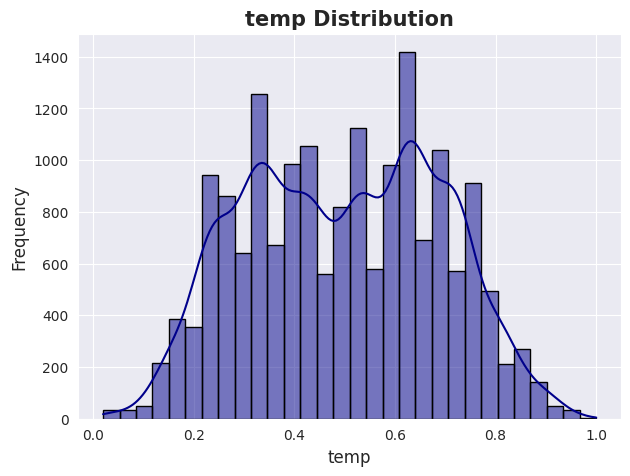

In [19]:
dist(df_hour, "temp")

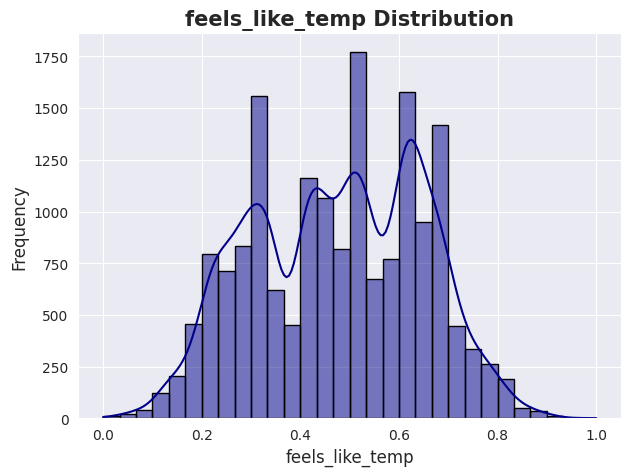

In [20]:
dist(df_hour, "feels_like_temp")

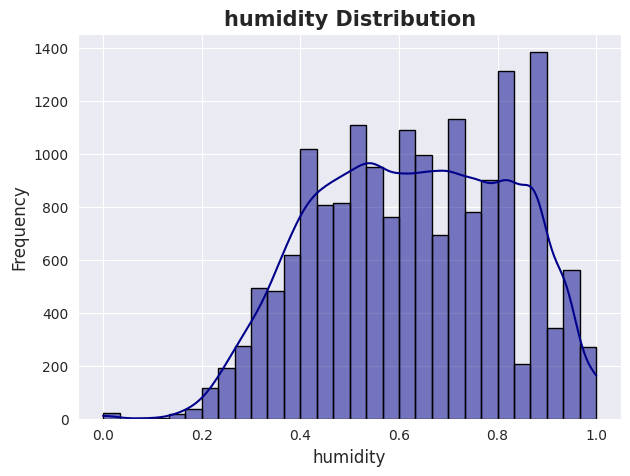

In [21]:
dist(df_hour, "humidity")

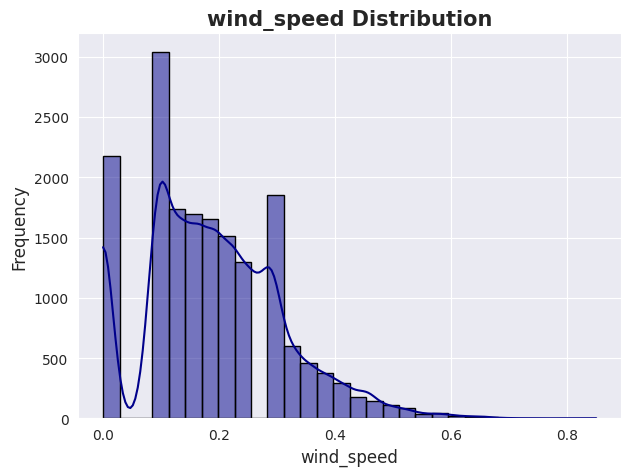

In [22]:
dist(df_hour, "wind_speed")

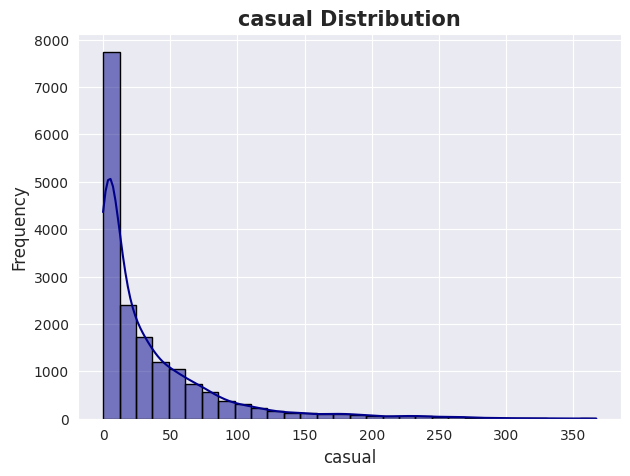

In [23]:
dist(df_hour, "casual")

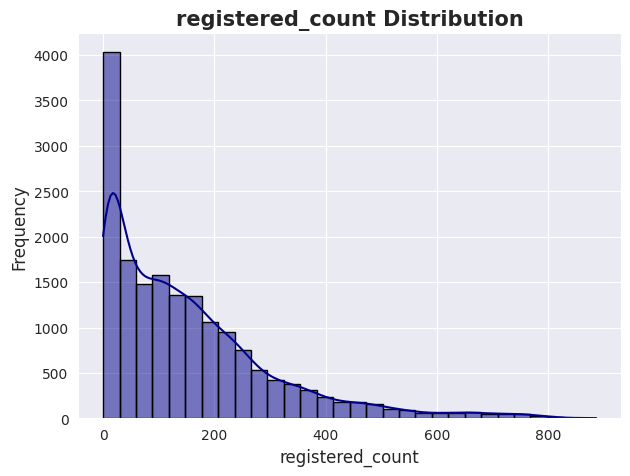

In [24]:
dist(df_hour, "registered_count")

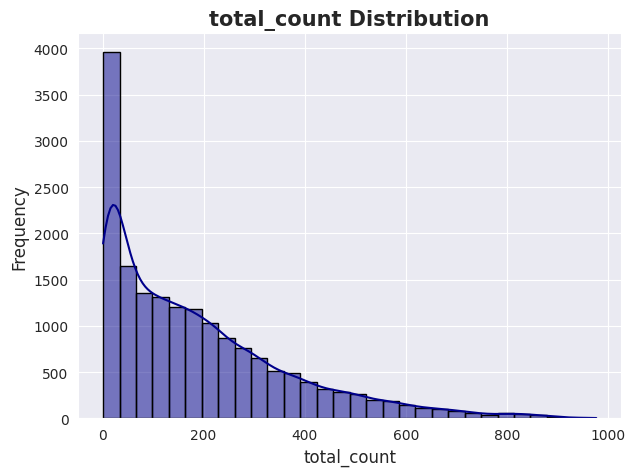

In [25]:
dist(df_hour, "total_count")

### Aggregated Barplot (Average)

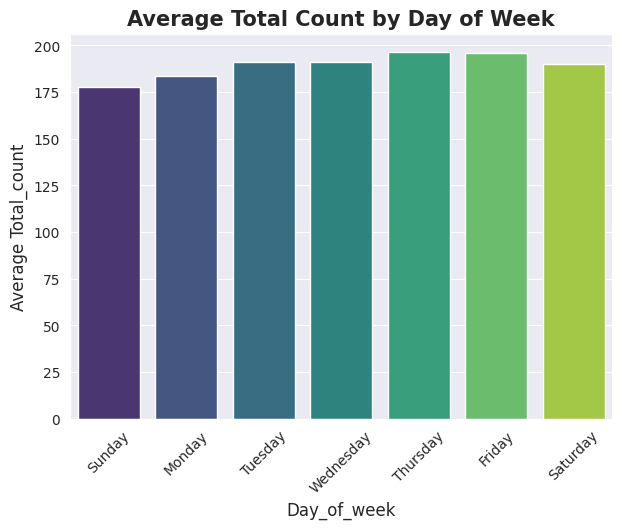

In [26]:
weekday_mean = df_hour.groupby("day_of_week")['total_count'].mean()
day_of_week_mapping = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

# Call the barplot function
barplot_aggregated(
    data=df_hour,
    col="day_of_week",
    agg_col="total_count",
    title="Average Total Count by Day of Week",
    x_labels=day_of_week_mapping
)

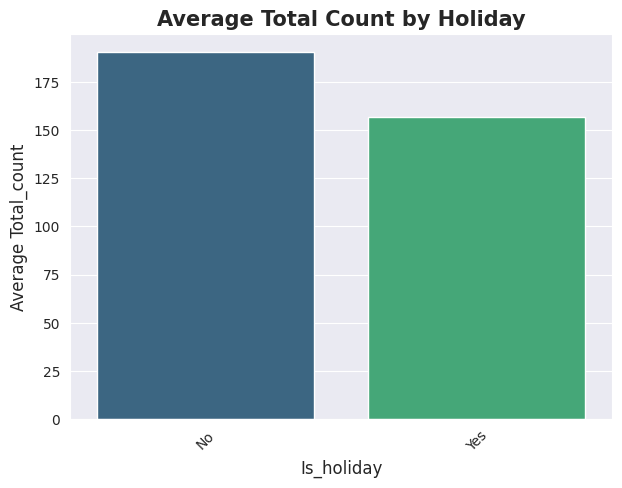

In [27]:
is_holiday_mean = df_hour.groupby("is_holiday")['total_count'].mean()
is_holiday_mapping = {
    0: "No",
    1: "Yes"
}

# Call the barplot function
barplot_aggregated(
    data=df_hour,
    col="is_holiday",
    agg_col="total_count",
    title="Average Total Count by Holiday",
    x_labels=is_holiday_mapping
)

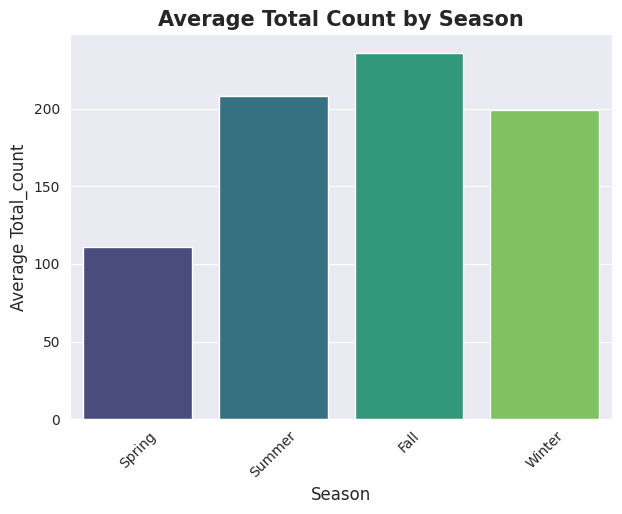

In [28]:
season_mean = df_hour.groupby("season")['total_count'].mean()
season_mean_mapping = {
    1: "Spring",
    2: "Summer",
    3: "Fall",
    4: "Winter"
}


# Call the barplot function
barplot_aggregated(
    data=df_hour,
    col="season",
    agg_col="total_count",
    title="Average Total Count by Season",
    x_labels=season_mean_mapping
)

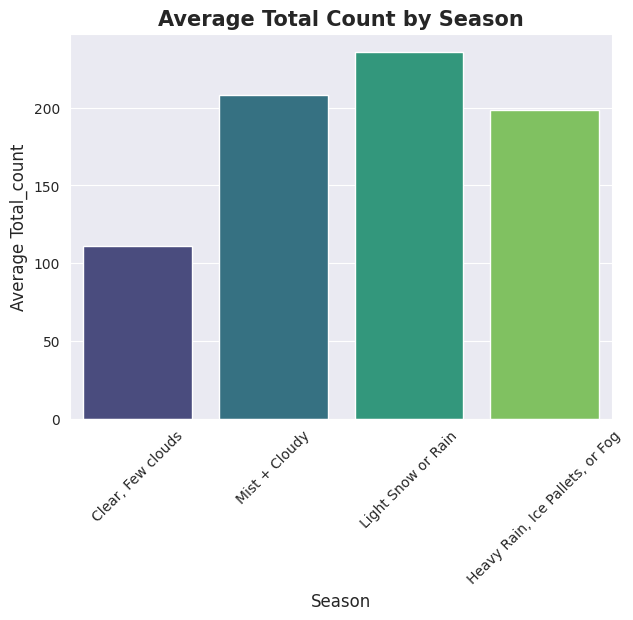

In [29]:
weather_situation_mean = df_hour.groupby("season")['total_count'].mean()
weather_situation_mean_mapping = {
    1: "Clear, Few clouds",
    2: "Mist + Cloudy",
    3: "Light Snow or Rain",
    4: "Heavy Rain, Ice Pallets, or Fog"
}

# Call the barplot function
barplot_aggregated(
    data=df_hour,
    col="season",
    agg_col="total_count",
    title="Average Total Count by Season",
    x_labels=weather_situation_mean_mapping
)

### Time-Series Analysis

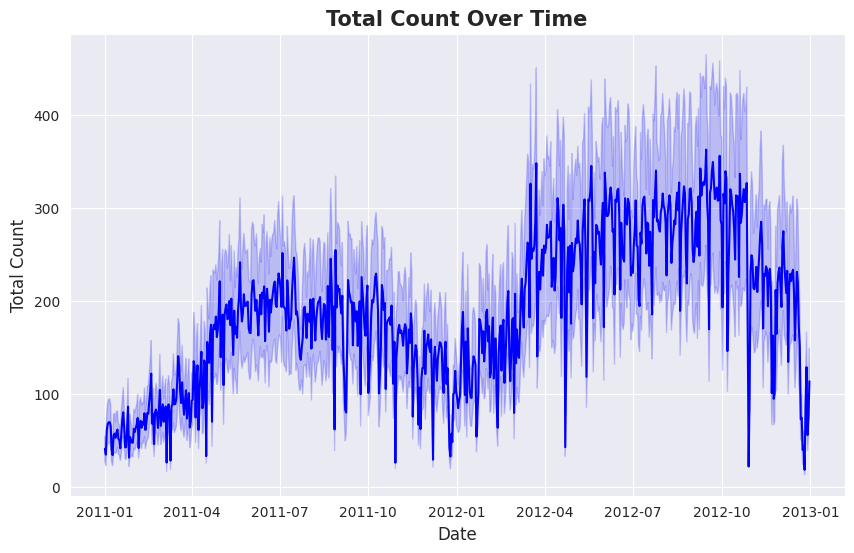

In [30]:
# Total Count Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_hour, x='date', y='total_count', color='blue')
plt.title("Total Count Over Time", fontsize=15, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Count", fontsize=12)
plt.show()

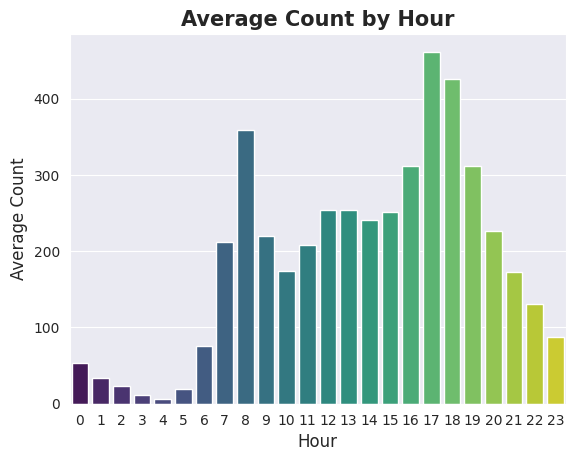

In [31]:
# Hourly Trends
hourly_mean = df_hour.groupby('hour')['total_count'].mean()
sns.barplot(x=hourly_mean.index, y=hourly_mean.values, palette='viridis')
plt.title("Average Count by Hour", fontsize=15, fontweight='bold')
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Average Count", fontsize=12)
plt.show()

### Scatterplot

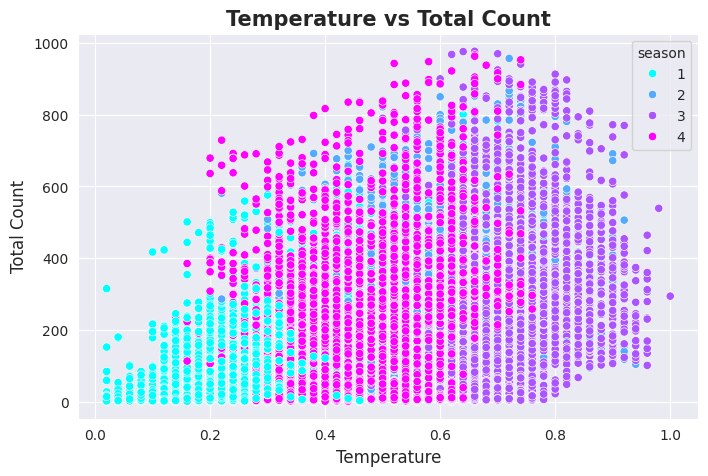

In [32]:
scatter_plot(
    df=df_hour,
    x_col='temp',
    y_col='total_count',
    hue_col='season',
    title="Temperature vs Total Count",
    x_label="Temperature",
    y_label="Total Count",
    palette='cool'
)

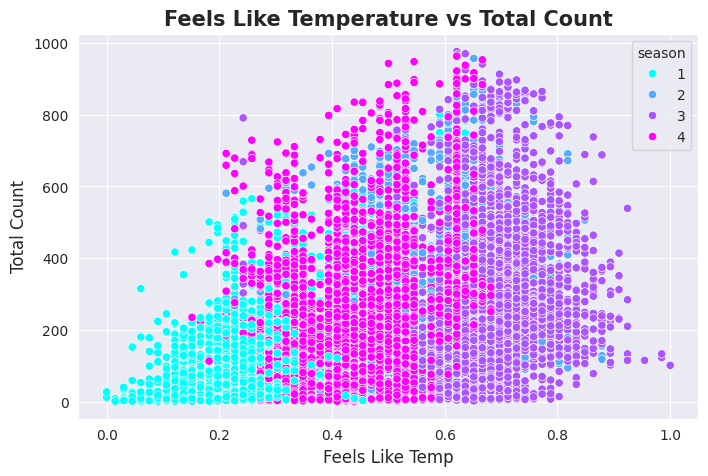

In [33]:
scatter_plot(
    df=df_hour,
    x_col='feels_like_temp',
    y_col='total_count',
    hue_col='season',
    title="Feels Like Temperature vs Total Count",
    x_label="Feels Like Temp",
    y_label="Total Count",
    palette='cool'
)

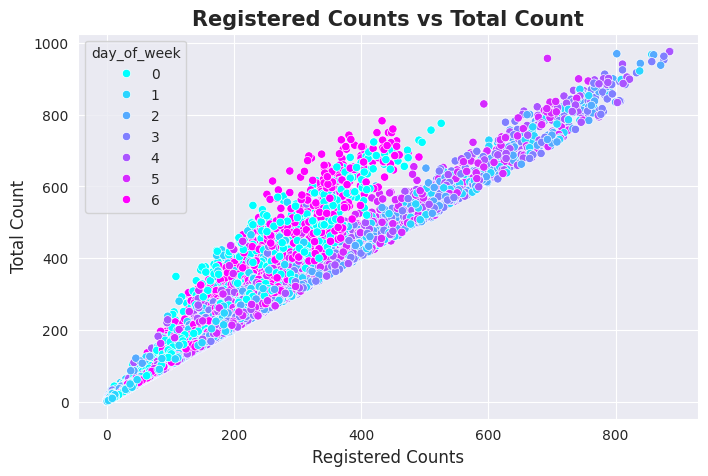

In [34]:
scatter_plot(
    df=df_hour,
    x_col='registered_count',
    y_col='total_count',
    hue_col='day_of_week',
    title="Registered Counts vs Total Count",
    x_label="Registered Counts",
    y_label="Total Count",
    palette='cool'
)

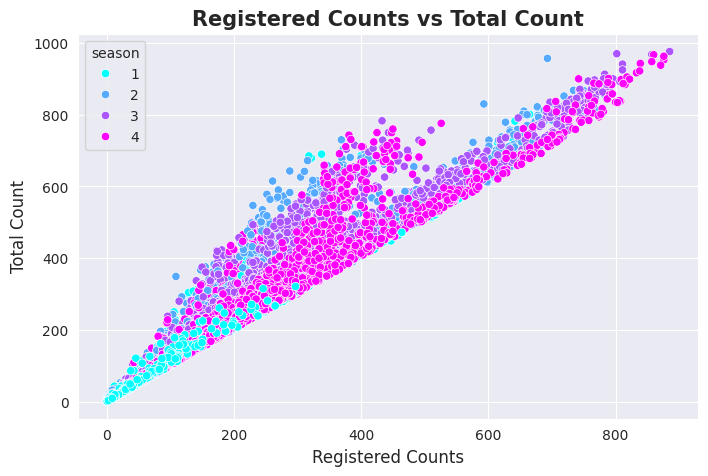

In [35]:
scatter_plot(
    df=df_hour,
    x_col='registered_count',
    y_col='total_count',
    hue_col='season',
    title="Registered Counts vs Total Count",
    x_label="Registered Counts",
    y_label="Total Count",
    palette='cool'
)

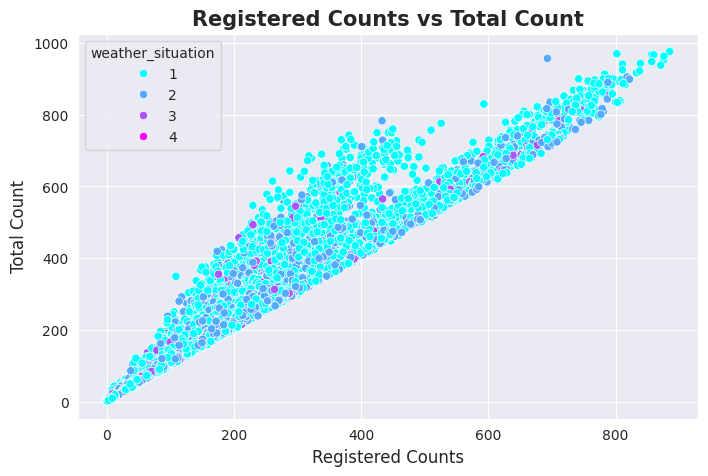

In [36]:
scatter_plot(
    df=df_hour,
    x_col='registered_count',
    y_col='total_count',
    hue_col='weather_situation',
    title="Registered Counts vs Total Count",
    x_label="Registered Counts",
    y_label="Total Count",
    palette='cool'
)

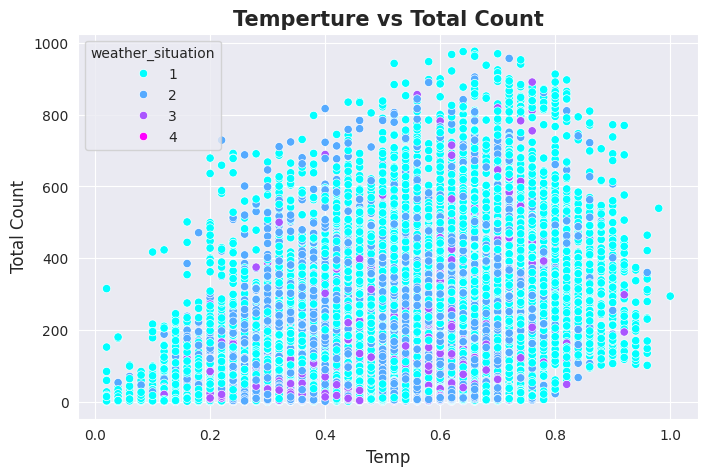

In [37]:
scatter_plot(
    df=df_hour,
    x_col='temp',
    y_col='total_count',
    hue_col='weather_situation',
    title="Temperture vs Total Count",
    x_label="Temp",
    y_label="Total Count",
    palette='cool'
)

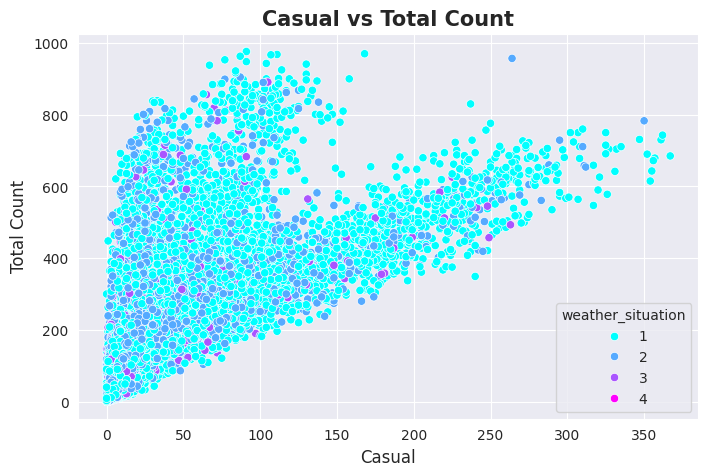

In [38]:
scatter_plot(
    df=df_hour,
    x_col='casual',
    y_col='total_count',
    hue_col='weather_situation',
    title="Casual vs Total Count",
    x_label="Casual",
    y_label="Total Count",
    palette='cool'
)

### Correlation

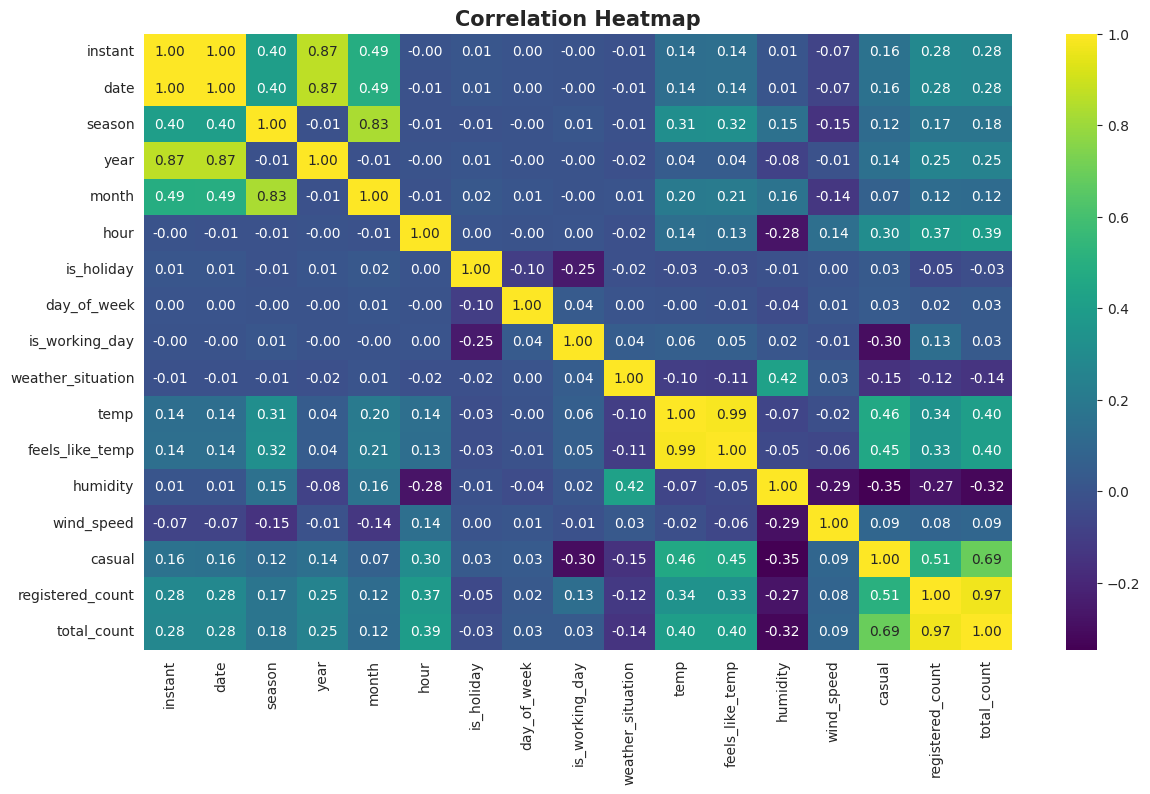

In [39]:
# Correlation
plt.figure(figsize=(14, 8))
sns.heatmap(df_hour.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap", fontsize=15, fontweight='bold')
plt.show()

### Boxplot

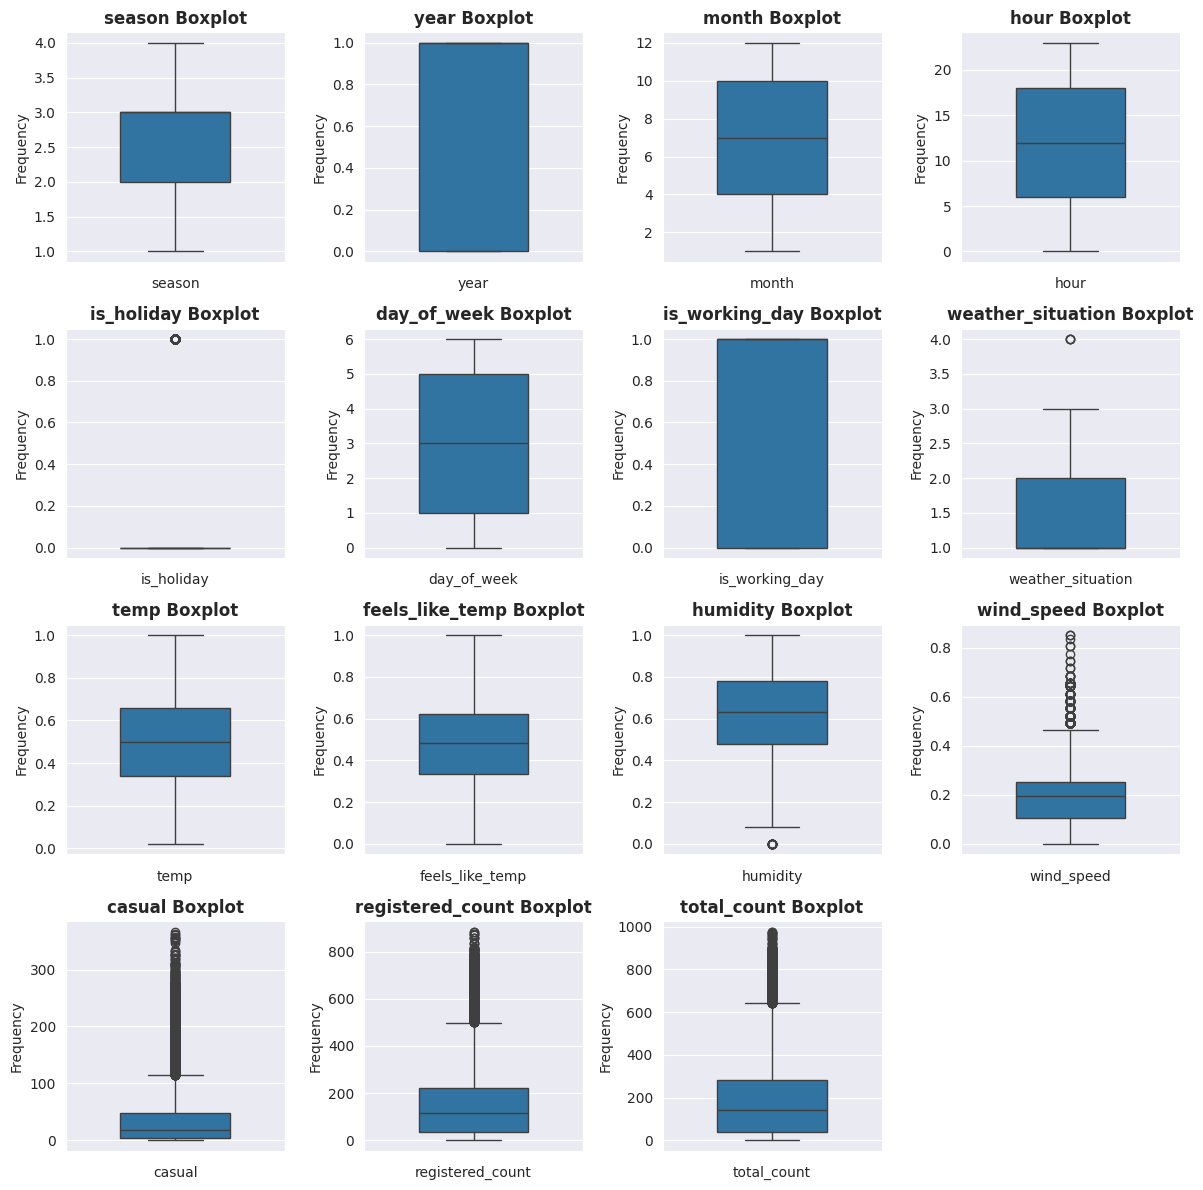

In [40]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(df_hour.columns[2:], 1):
    plt.subplot(4, 4, i)
    sns.set_style("darkgrid")
    sns.boxplot(data=df_hour, y=col, width=0.5)
    plt.title(f"{col} Boxplot", fontsize=12, fontweight='bold')
    plt.xlabel(f"{col}", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Detect & Replace Outlier

In [41]:
def calculate_outlier_thresholds(
    dataframe: pd.DataFrame, variable: str, low_quantile: float = 0.25, up_quantile: float = 0.75):
    """
    Calculate the lower and upper thresholds for outlier detection using the interquartile range method.

    Args:
        dataframe (pd.DataFrame): The data frame containing the variable.
        variable (str): The name of the column to calculate thresholds for.
        low_quantile (float): The lower quantile threshold (default: 0.10).
        up_quantile (float): The upper quantile threshold (default: 0.90).

    Returns:
        Tuple[float, float]: The lower and upper outlier thresholds.
    """
    q1 = dataframe[variable].quantile(low_quantile)
    q3 = dataframe[variable].quantile(up_quantile)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    return lower_limit, upper_limit

In [42]:
def has_outliers(dataframe: pd.DataFrame, column: str) -> bool:
    """
    Check if a column contains outliers based on the calculated thresholds.

    Args:
        dataframe (pd.DataFrame): The data frame containing the column.
        column (str): The column to check for outliers.

    Returns:
        bool: True if outliers exist, False otherwise.
    """
    lower_limit, upper_limit = calculate_outlier_thresholds(dataframe, column)
    return dataframe[(dataframe[column] < lower_limit) | (dataframe[column] > upper_limit)].any().any()

# Checking for outliers across numerical columns
for column in df_hour.columns:
    if column != "Premium Amount":
        has_outlier = has_outliers(df_hour, column)
        print(f"Column: {column}, Outliers Present: {has_outlier}")

Column: instant, Outliers Present: False
Column: date, Outliers Present: False
Column: season, Outliers Present: False
Column: year, Outliers Present: False
Column: month, Outliers Present: False
Column: hour, Outliers Present: False
Column: is_holiday, Outliers Present: True
Column: day_of_week, Outliers Present: False
Column: is_working_day, Outliers Present: False
Column: weather_situation, Outliers Present: True
Column: temp, Outliers Present: False
Column: feels_like_temp, Outliers Present: False
Column: humidity, Outliers Present: True
Column: wind_speed, Outliers Present: True
Column: casual, Outliers Present: True
Column: registered_count, Outliers Present: True
Column: total_count, Outliers Present: True


In [43]:
def replace_outliers_with_thresholds(
    dataframe: pd.DataFrame, variable: str
) -> None:
    """
    Replace outliers in a column with the calculated lower and upper threshold values.

    Args:
        dataframe (pd.DataFrame): The data frame containing the variable.
        variable (str): The column where outliers will be replaced.
    """
    lower_limit, upper_limit = calculate_outlier_thresholds(dataframe, variable)
    dataframe[variable] = dataframe[variable].clip(lower=lower_limit, upper=upper_limit)

# Replacing outliers with thresholds across numerical columns
for column in df_hour.columns:
    if column != "Premium Amount":
        replace_outliers_with_thresholds(df_hour, column)
        print(f"Outliers replaced for column: {column}")

Outliers replaced for column: instant
Outliers replaced for column: date
Outliers replaced for column: season
Outliers replaced for column: year
Outliers replaced for column: month
Outliers replaced for column: hour
Outliers replaced for column: is_holiday
Outliers replaced for column: day_of_week
Outliers replaced for column: is_working_day
Outliers replaced for column: weather_situation
Outliers replaced for column: temp
Outliers replaced for column: feels_like_temp
Outliers replaced for column: humidity
Outliers replaced for column: wind_speed
Outliers replaced for column: casual
Outliers replaced for column: registered_count
Outliers replaced for column: total_count


### Encoding

In [44]:
# Define actual values mapping dict
day_of_week_mapping = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday"
}

season_mean_mapping = {
    1: "Spring",
    2: "Summer",
    3: "Fall",
    4: "Winter"
}

weather_situation_mean_mapping = {
    1: "Clear, Few clouds",
    2: "Mist + Cloudy",
    3: "Light Snow or Rain",
    4: "Heavy Rain, Ice Pallets, or Fog"
}

month_mapping = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}


# Add actual values of encoded values:
df_hour['day_of_week'] = df_hour['day_of_week'].map(day_of_week_mapping)
df_hour['season'] = df_hour['season'].map(season_mean_mapping)
df_hour['weather_situation'] = df_hour['weather_situation'].map(weather_situation_mean_mapping)
df_hour['month'] = df_hour['month'].map(month_mapping)

In [45]:
categorical_columns = ['day_of_week', 'season', 'weather_situation', 'month']

# Initialize the BinaryEncoder
binary_encoder = ce.BinaryEncoder(cols=categorical_columns, return_df=True)
df_hour_encoded = binary_encoder.fit_transform(df_hour)

# df_hour_encoded now contains binary-encoded categorical columns
df_hour_encoded.head()

,instant,date,season_0,season_1,season_2,year,month_0,month_1,month_2,month_3,...,weather_situation_0,weather_situation_1,weather_situation_2,temp,feels_like_temp,humidity,wind_speed,casual,registered_count,total_count
0,1,2011-01-01,0,0,1,0,0,0,0,1,...,0,0,1,0.24,0.2879,0.81,0.0,3,13,16.0
1,2,2011-01-01,0,0,1,0,0,0,0,1,...,0,0,1,0.22,0.2727,0.80,0.0,8,32,40.0
2,3,2011-01-01,0,0,1,0,0,0,0,1,...,0,0,1,0.22,0.2727,0.80,0.0,5,27,32.0
3,4,2011-01-01,0,0,1,0,0,0,0,1,...,0,0,1,0.24,0.2879,0.75,0.0,3,10,13.0
4,5,2011-01-01,0,0,1,0,0,0,0,1,...,0,0,1,0.24,0.2879,0.75,0.0,0,1,1.0


In [46]:
print(f"Original Data Shape: {df_hour.shape}")
print(f"Encoded Data Shape: {df_hour_encoded.shape}")

Original Data Shape: (17379, 17)
Encoded Data Shape: (17379, 26)


### Handle Skewness Of Numerical Variables

In [47]:
def handle_skewness(df, col, threshold=0.75):
    """
    Adjusts the skewness of a specified column in a DataFrame without modifying the original DataFrame.

    Parameters:
    df (pd.DataFrame): The original DataFrame (untouched).
    col (str): The column name to check and adjust for skewness.
    threshold (float, optional): The skewness threshold to apply transformations.
                                  Default is 1.0.

    Transformations:
    - If skewness > threshold: Apply log transformation.
    - If skewness < -threshold: Apply square transformation.

    Returns:
    pd.DataFrame: A new DataFrame with adjusted skewness for the specified column.
    """
    df_copy = df.copy()  # Create a copy of the DataFrame
    col_skew = df_copy[col].skew()
    if col_skew > threshold:  # Positive skew
        df_copy[col] = np.log1p(df_copy[col])
    elif col_skew < -threshold:  # Negative skew
        df_copy[col] = np.square(df_copy[col])
    return df_copy


In [48]:
cols = ['total_count', 'registered_count', 'casual', 'wind_speed', 'humidity']
df_hour_transformed = df_hour_encoded.copy()  # Start with a copy of the original DataFrame

for col in cols:
    df_hour_transformed = handle_skewness(df_hour_transformed, col, threshold=0.75)

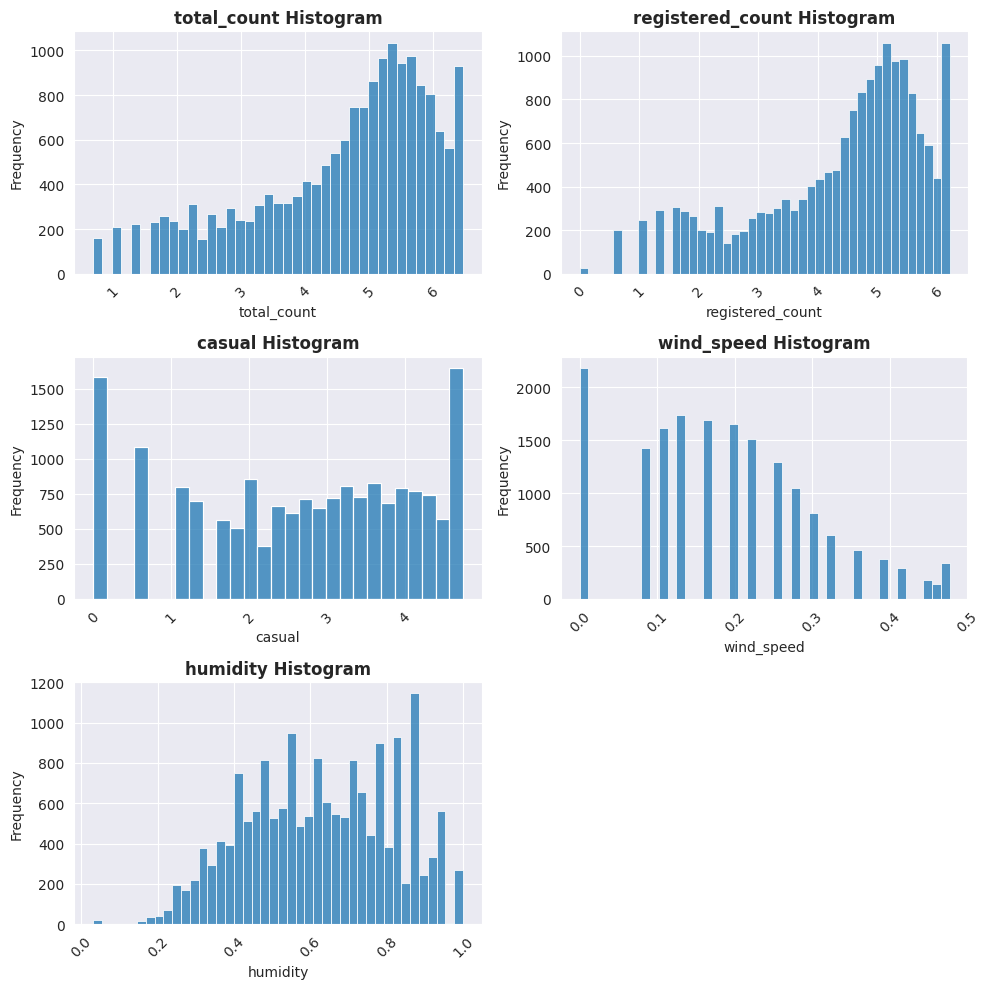

In [49]:
plt.figure(figsize=(10, 10))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 2, i)
    sns.set_style("darkgrid")
    sns.histplot(data=df_hour_transformed, x=col)
    plt.title(f"{col} Histogram", fontsize=12, fontweight='bold')
    plt.xlabel(f"{col}", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Define Model

### Split X, y

In [50]:
X = df_hour_transformed.drop(["total_count", "date", 'instant'], axis=1)
y = df_hour_transformed['total_count']

print("X Shape: ", X.shape)
print("y Shape: ", y.shape)

X Shape:  (17379, 23)
y Shape:  (17379,)


### Split Train/Test

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")
print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")

X_train Shape: (13903, 23)
X_test Shape: (3476, 23)
y_train Shape: (13903,)
y_test Shape: (3476,)
X_val Shape: (2781, 23)
y_val Shape: (2781,)


### Define & Evaluate Models

In [52]:
algorithms = {
    'LinearRegression': LinearRegression,
    'DecisionTree': DecisionTreeRegressor,
    'RandomForest': RandomForestRegressor,
    'GradientBoosting': GradientBoostingRegressor,
    'LightGBM': LGBMRegressor,
    'XGBRegressor': XGBRegressor
}

for algorithm_name, algorithm in algorithms.items():
    model = algorithm()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{algorithm_name} MSE: {mse}")
    print(f"{algorithm_name} R2: {r2_score(y_test, y_pred)}")
    print("==" * 40 + "\n")

LinearRegression MSE: 0.008011918605499194
LinearRegression R2: 0.9958959314266864

DecisionTree MSE: 0.0011895980323664817
DecisionTree R2: 0.9993906338618868

RandomForest MSE: 0.0004913241556578361
RandomForest R2: 0.9997483214538448

GradientBoosting MSE: 0.0013032920179888105
GradientBoosting R2: 0.999332394639006

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 13903, number of used features: 21
[LightGBM] [Info] Start training from score 4.573634
LightGBM MSE: 0.0007151600506501005
LightGBM R2: 0.9996336625428586

XGBRegressor MSE: 0.0005670035336216873
XGBRegressor R2: 0.9997095550394511



### Fine Tunning XGBoostRegressor

In [53]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=700,
    learning_rate=0.01,
    max_depth=8,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

# Fit XGBRegressor Model
xgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=True)

[0]	validation_0-rmse:1.38061
[1]	validation_0-rmse:1.36816
[2]	validation_0-rmse:1.35463
[3]	validation_0-rmse:1.34132
[4]	validation_0-rmse:1.32807
[5]	validation_0-rmse:1.31487
[6]	validation_0-rmse:1.30321
[7]	validation_0-rmse:1.29039
[8]	validation_0-rmse:1.27761
[9]	validation_0-rmse:1.26499
[10]	validation_0-rmse:1.25256
[11]	validation_0-rmse:1.24018
[12]	validation_0-rmse:1.22789
[13]	validation_0-rmse:1.21576
[14]	validation_0-rmse:1.20380
[15]	validation_0-rmse:1.19190
[16]	validation_0-rmse:1.18018
[17]	validation_0-rmse:1.16859
[18]	validation_0-rmse:1.15703
[19]	validation_0-rmse:1.14560
[20]	validation_0-rmse:1.13547
[21]	validation_0-rmse:1.12426
[22]	validation_0-rmse:1.11382
[23]	validation_0-rmse:1.10288
[24]	validation_0-rmse:1.09200
[25]	validation_0-rmse:1.08120
[26]	validation_0-rmse:1.07120
[27]	validation_0-rmse:1.06068
[28]	validation_0-rmse:1.05020
[29]	validation_0-rmse:1.03990
[30]	validation_0-rmse:1.02965
[31]	validation_0-rmse:1.01948
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
# Make predictions on the test set
print(" ===  Evaluate TEST SET ===\n")
y_pred_text = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_text)
r2 = r2_score(y_test, y_pred_text)
print(f"Mean Squared Error : {mse:.5f}")
print(f"R-squared: {r2:.5f}")

print("-"* 30 + "\n")
print(" ===  Evaluate TRAIN SET ===\n")
# Evaluate Model on train set
y_pred_train = xgb_model.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print(f"Mean Squared Error: {mse:.5f}")
print(f"R-squared: {r2:.5f}")

print("-"* 30 + "\n")
print(" ===  Evaluate VALIDATION SET ===\n")
# Evaluate Model on train set
y_pred_val = xgb_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
print(f"Mean Squared Error: {mse:.5f}")
print(f"R-squared: {r2:.5f}")

 ===  EVALUTE TEST SET ===

Mean Squared Error : 0.00145
R-squared: 0.99926
------------------------------

 ===  EVALUTE TRAIN SET ===

Mean Squared Error: 0.00110
R-squared: 0.99945
------------------------------

 ===  EVALUTE VALIDATION SET ===

Mean Squared Error: 0.00108
R-squared: 0.99945
